# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Metrics
from sklearn.metrics import mean_squared_error as mse

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 15 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [3]:
data = pd.read_csv("winequalityN.csv")
print ('Dataset:' , 'data' , data.shape)

Dataset: data (6497, 13)


## 2.4 Статистика и визуализации

In [4]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol

Output variable (based on sensory data):

- 12 - quality (score between 0 and 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

In [5]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


### 2.4.1 Посмотрим на распределение признаков

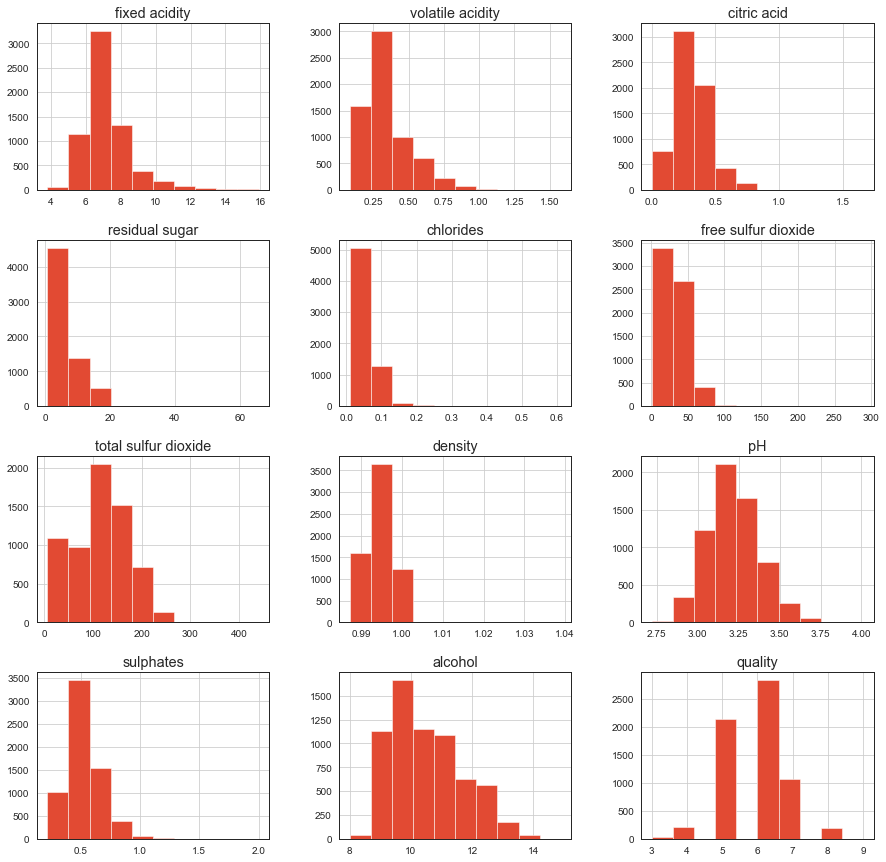

In [7]:
data.hist(figsize=(15,15))
plt.show()

<AxesSubplot:>

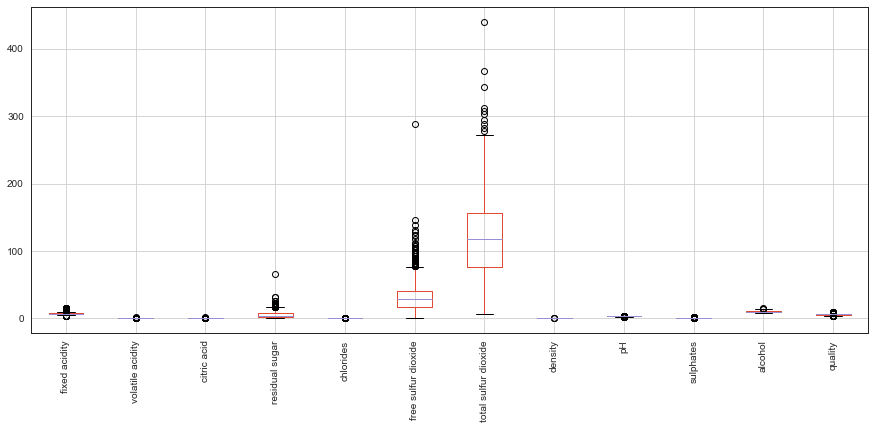

In [8]:
data.boxplot(figsize=(15,6), rot=90)

Признаки распределены нормально, аномальных выбросов не обнаружено

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

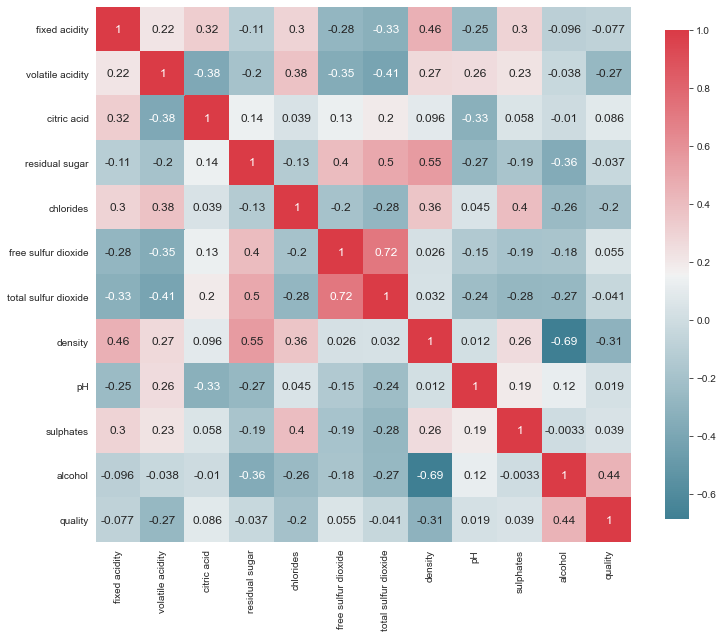

In [9]:
plot_correlation_map( data )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством вина
Начнем с рассмотрения взаимосвязи между возрастом и выживанием.

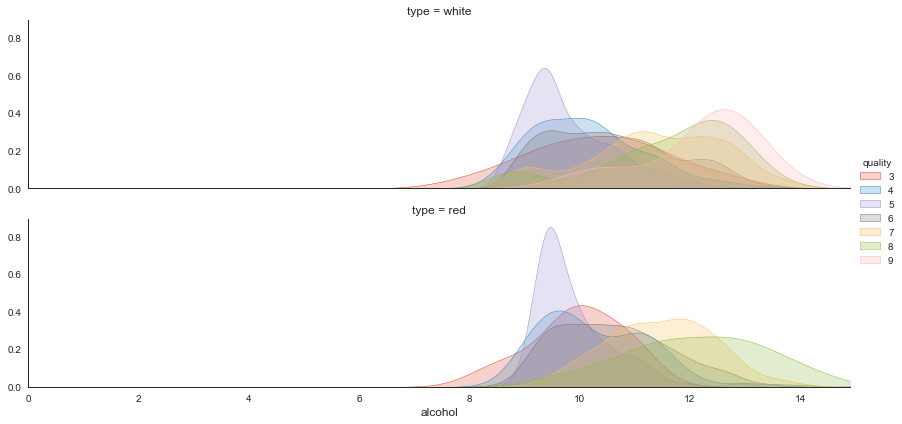

In [10]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

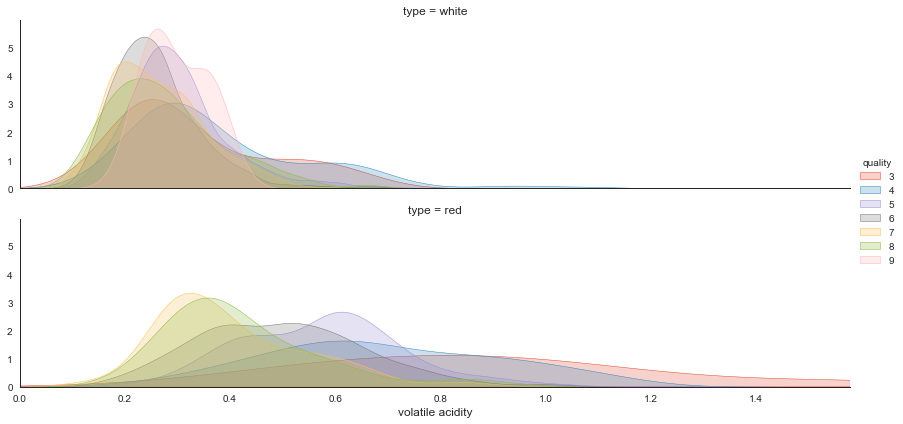

In [11]:
plot_distribution( data , var = 'volatile acidity' , target = 'quality' , row = 'type' )

### 2.4.4 Тип вина
Мы также можем посмотреть на категориальные переменные, такие как тип вина и их связь с качеством

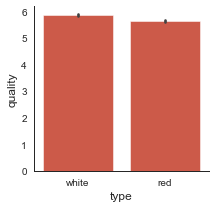

In [12]:
plot_categories( data , cat = 'type' , target = 'quality' )

# 3. Data Preparation

## 3.1 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [13]:
# Create dataset
imputed = data.copy()

# Fill missing values of fixed acidity with the average of fixed acidity (mean)
imputed[ 'fixed acidity' ] = data['fixed acidity'].fillna( data['fixed acidity'].mean() )

# Fill missing values of volatile acidity with the average of volatile acidity (mean)
imputed[ 'volatile acidity' ] = data['volatile acidity'].fillna( data['volatile acidity'].mean() )

# Fill missing values of citric acid with the average of citric acid (mean)
imputed[ 'citric acid' ] = data['citric acid'].fillna( data['citric acid'].mean() )

# Fill missing values of residual sugar with the average of residual sugar (mean)
imputed[ 'residual sugar' ] = data['residual sugar'].fillna( data['residual sugar'].mean() )

# Fill missing values of chlorides with the average of chlorides (mean)
imputed[ 'chlorides' ] = data['chlorides'].fillna( data['chlorides'].mean() )

# Fill missing values of pH with the average of pH (mean)
imputed[ 'pH' ] = data['pH'].fillna( data['pH'].mean() )

# Fill missing values of sulphates with the average of sulphates (mean)
imputed[ 'sulphates' ] = data['sulphates'].fillna( data['sulphates'].mean() )

imputed.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3.2 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная type рассматривается как категориальная переменная. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому закодируем красное вино цифрой 1, белое - 0

In [14]:
imputed.type = np.where( imputed.type == 'red' , 1 , 0 ) 

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection
Выбираем признаки для формирования итогового датасет. У нас доступны признаки:

- type
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol


Посмотрим информацию по финальному датасету

In [15]:
imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int32  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 634.6 KB


Сохраним датасет в файл в качестве промежуточных данных

In [16]:
imputed.to_csv( 'imputed.csv' , index = False )

### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [17]:
# Create all datasets that are necessary to train and test models
train_X , test_X , train_y , test_y = train_test_split( imputed.iloc[:, :-1] , imputed.quality , train_size = .7 )

print (data.shape , train_X.shape , train_y.shape , test_X.shape , test_y.shape)

(6497, 13) (4547, 12) (4547,) (1950, 12) (1950,)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


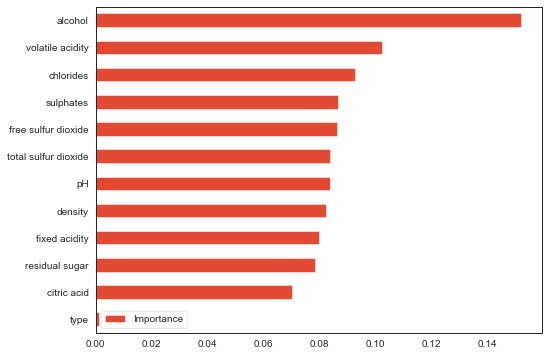

In [18]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является линейная регрессия.

In [19]:
model = LinearRegression()
# model = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
# model = RandomForestClassifier()

## 4.2 Обучение модели

In [20]:
model.fit( train_X , train_y )

LinearRegression()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [21]:
# Score the model
print (model.score( train_X , train_y ) , model.score( test_X , test_y ))

0.3013729247604964 0.28341225208934295


Посмотрим на среднеквадратичное отклонение на тестовых данных

In [22]:
print(mse(model.predict(test_X), test_y))

0.5821140501159549


# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [23]:
Y = model.predict(imputed.iloc[:, :-1])

In [24]:
test_Y = model.predict( test_X )
predict = pd.DataFrame( { 'PassengerId': data.index , 'Survived': Y } )
predict.shape
predict.head()
predict.to_csv( 'pred.csv' , index = False )